# VARMA Forecasting Methods

hohohohoh...

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import grangercausalitytests

import warnings
warnings.filterwarnings('ignore')

import statsmodels.api as sm
import pmdarima as pm

In [2]:
df=pd.read_excel('Traffic.xlsx')

df['Start Time'] = pd.to_datetime(df['Start Time'])
df.set_index('Start Time',drop=False,inplace=True)
df['DL RBLER (%)']=df['DL RBLER (%)'].replace('NIL',np.nan)
df['DL RBLER (%)']=df['DL RBLER (%)'].astype(float)
df['DL RBLER (%)'].fillna(df['DL RBLER (%)'].median(),inplace=True)
df['DL user tput']=df['L.Thrp.bits.DL.QCI.9 (bit)']/(df['L.Thrp.Time.DL.QCI.9 (ms)']*1000)
df['DL cell tput']=df['L.Thrp.bits.DL (bit)']/(df['L.Thrp.Time.Cell.DL (s)']*1000000)

df['DL user tput']=df['DL user tput'].replace(np.nan,0)
df['DL cell tput']=df['DL cell tput'].replace(np.nan,0)

df_filter=df[df['Cell']=='Local cell identity=2, Cell Name=eNB_3401-2']

df_filter=df_filter.drop('Cell',axis=1)

df_filter.index.freq='15T'
df_filter.index

DatetimeIndex(['2013-08-28 00:00:00', '2013-08-28 00:15:00',
               '2013-08-28 00:30:00', '2013-08-28 00:45:00',
               '2013-08-28 01:00:00', '2013-08-28 01:15:00',
               '2013-08-28 01:30:00', '2013-08-28 01:45:00',
               '2013-08-28 02:00:00', '2013-08-28 02:15:00',
               ...
               '2013-09-04 21:30:00', '2013-09-04 21:45:00',
               '2013-09-04 22:00:00', '2013-09-04 22:15:00',
               '2013-09-04 22:30:00', '2013-09-04 22:45:00',
               '2013-09-04 23:00:00', '2013-09-04 23:15:00',
               '2013-09-04 23:30:00', '2013-09-04 23:45:00'],
              dtype='datetime64[ns]', name='Start Time', length=768, freq='15T')

In the previous notebook we created an SARIMA model to create forecasts. The forecasts were solely on the combination of previous values and errors from the same timeseries
In the case of VARMA, the idea is to use other timeseries data that could be correlated with the one we wish to forecast and put it's previous values (and errors) as inputs to the linear model

for our usecase where we want to forecast DL user tput, we can have the number of connected users as an input. The idea is that this new variable could help with getting better predictions as it is known that a change in tput is usually preceeded by a change in the number of users. At a low number of users the increase in the number of users does not immediately have an effect, which should help with better predictions. The below exercise is test this theory

Let's put the two variables LD user tput and number of connected users (L.Traffic.User.Avg (None)) in a dataframe

In [3]:
df_varma=df_filter[['L.Traffic.User.Avg (None)','DL user tput']]

In VARMA models, the user needs to first make sure that the two timeseries signals are stationary. For 'DL user tput' we need to do seasonal+non-seasonal differencing as done in the previous notebook. For number if users we need to repeat the exercise and see

In [4]:
df_varma

,L.Traffic.User.Avg (None),DL user tput
Start Time,,
2013-08-28 00:00:00,128.430,0.684966
2013-08-28 00:15:00,129.181,0.566828
2013-08-28 00:30:00,126.616,0.613085
2013-08-28 00:45:00,130.703,0.578675
2013-08-28 01:00:00,130.700,0.481141
...,...,...
2013-09-04 22:45:00,109.154,1.007606
2013-09-04 23:00:00,109.387,1.110101
2013-09-04 23:15:00,114.732,1.000562


In [5]:
def adf(x):
  result=adfuller(x)
  print("p-value:",result[1])
  if result[1]<0.05:
    print("Stationary")
  else:
    print("non-stationary")

In [6]:
df_varma['1st_diff_users']=df_varma['L.Traffic.User.Avg (None)'].diff(96)
df_varma['1st_diff_users'].fillna(df_varma['1st_diff_users'].median(),inplace=True)

df_varma['2nd_diff_users'] = df_varma['1st_diff_users'].diff()
df_varma['2nd_diff_users'].fillna(df_varma['2nd_diff_users'].median(),inplace=True)

adf(df_varma['2nd_diff_users'])

p-value: 2.9285868406032733e-30
Stationary


We get a stationary signal by doing twice (seasonal+non-seasonal) differencing similar to DL user tput.

Let's look at ACF and PACF

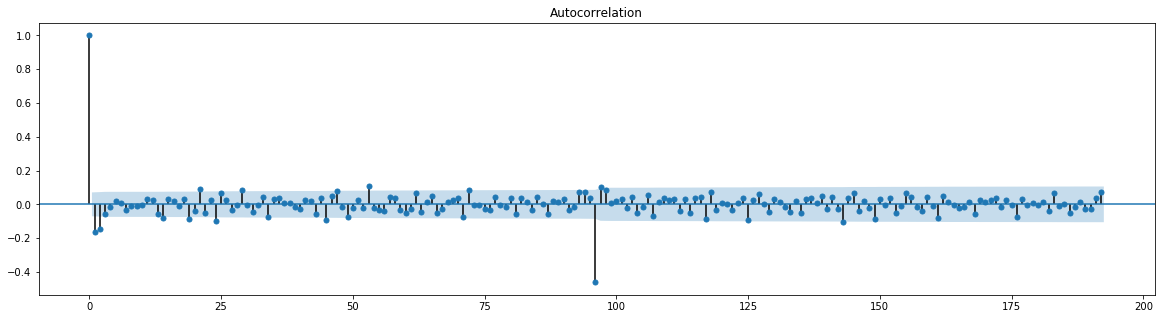

In [7]:
fig,ax=plt.subplots(figsize=(20,5))

plot_acf(df_varma['2nd_diff_users'],ax=ax,lags =192);

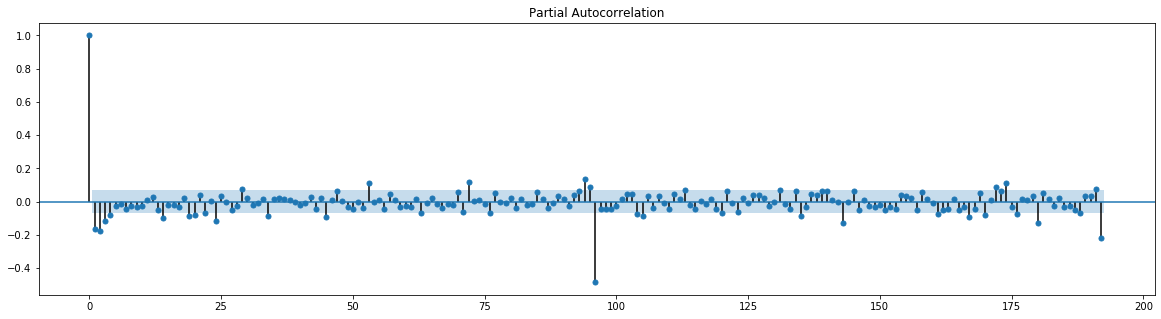

In [8]:
fig,ax=plt.subplots(figsize=(20,5))

plot_pacf(df_varma['2nd_diff_users'],ax=ax,lags =192);

In [4]:
Samtest=96
train=df_varma.iloc[:-Samtest]
test=df_varma.iloc[-Samtest:]


train_idx=df_filter.index <= train.index[-1]
test_idx=df_filter.index > train.index[-1]

In [5]:
scalert = StandardScaler()
# transform data
train['scaled_tput'] = scalert.fit_transform(train[['DL user tput']])
test['scaled_tput'] = scalert.transform(test[['DL user tput']])

scaleru = StandardScaler()
# transform data
train['scaled_users'] = scaleru.fit_transform(train[['L.Traffic.User.Avg (None)']])
test['scaled_users'] = scaleru.transform(test[['L.Traffic.User.Avg (None)']])




In [6]:
df_varma.loc[train_idx,'scaled_tput']=train['scaled_tput']
df_varma.loc[test_idx,'scaled_tput']=test['scaled_tput']

df_varma.loc[train_idx,'scaled_users']=train['scaled_users']
df_varma.loc[test_idx,'scaled_users']=test['scaled_users']

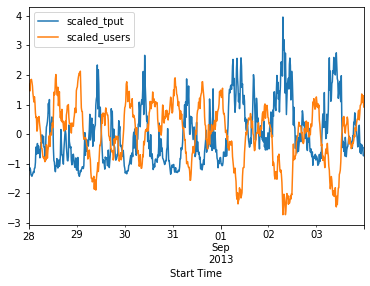

In [7]:
cols=['scaled_tput','scaled_users']

train[cols].plot()

In [8]:
model=VAR(train[cols])

In [89]:
lag_order_results=model.select_order(maxlags=100)
lag_order_results

In [90]:
lag_order_results.selected_orders

{'aic': 7, 'bic': 1, 'hqic': 2, 'fpe': 7}

In [9]:
results=model.fit(96)

#model.fit?

In [10]:
#lag_order=results.k_ar

lag_order=96

In [11]:
prior=train.iloc[-lag_order:][cols].to_numpy()
fcast=results.forecast(prior,Samtest)

In [94]:
lag_order

75

In [12]:

df_varma.loc[train_idx,'Train Pred tput']=train['scaled_tput']
df_varma.loc[test_idx,'Test Pred tput']=fcast[:,0]

#df_varma.loc[train_idx,'Train Pred users']=train['L.Traffic.User.Avg (None)']
#df_varma.loc[test_idx,'Test Pred users']=test['L.Traffic.User.Avg (None)']

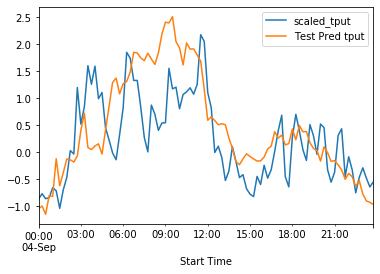

In [13]:
plot_cols=['scaled_tput','Train Pred tput','Test Pred tput']
df_varma.iloc[-96:][plot_cols][['scaled_tput','Test Pred tput']].plot()

In [14]:
def rmsefun(result,is_logged):
  y=result.forecast(Samtest)
  if is_logged:
    y=np.exp(y)
  t=test['DL user tput']
  return 


In [15]:
np.sqrt(mean_squared_error(scalert.inverse_transform(df_varma.iloc[-96:][plot_cols]['scaled_tput']),scalert.inverse_transform(df_varma.iloc[-96:][plot_cols]['Test Pred tput'])))

0.42411577987888366

In [ ]:
scaleru.inverse_transform(df_varma.iloc[-96:][plot_cols]['Test Pred tput'])

In [16]:
arima=ARIMA(train['scaled_tput'],order=(96,0,0))
arima_result=arima.fit()

In [17]:

y=arima_result.forecast(Samtest)
t=test['scaled_tput']


In [18]:
np.sqrt(mean_squared_error(scalert.inverse_transform(y),scalert.inverse_transform(t)))

0.3988678899688352

In [25]:
granger_results=grangercausalitytests(df_varma[['scaled_tput','scaled_users']],maxlag=100)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=67.0180 , p=0.0000  , df_denom=764, df_num=1
ssr based chi2 test:   chi2=67.2811 , p=0.0000  , df=1
likelihood ratio test: chi2=64.4922 , p=0.0000  , df=1
parameter F test:         F=67.0180 , p=0.0000  , df_denom=764, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=28.5237 , p=0.0000  , df_denom=761, df_num=2
ssr based chi2 test:   chi2=57.4222 , p=0.0000  , df=2
likelihood ratio test: chi2=55.3718 , p=0.0000  , df=2
parameter F test:         F=28.5237 , p=0.0000  , df_denom=761, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=18.2571 , p=0.0000  , df_denom=758, df_num=3
ssr based chi2 test:   chi2=55.2771 , p=0.0000  , df=3
likelihood ratio test: chi2=53.3713 , p=0.0000  , df=3
parameter F test:         F=18.2571 , p=0.0000  , df_denom=758, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=13.4310 , p=0.0000  

ssr based chi2 test:   chi2=88.0907 , p=0.0000  , df=31
likelihood ratio test: chi2=83.2113 , p=0.0000  , df=31
parameter F test:         F=2.5987  , p=0.0000  , df_denom=674, df_num=31

Granger Causality
number of lags (no zero) 32
ssr based F test:         F=2.7202  , p=0.0000  , df_denom=671, df_num=32
ssr based chi2 test:   chi2=95.4786 , p=0.0000  , df=32
likelihood ratio test: chi2=89.7739 , p=0.0000  , df=32
parameter F test:         F=2.7202  , p=0.0000  , df_denom=671, df_num=32

Granger Causality
number of lags (no zero) 33
ssr based F test:         F=2.6580  , p=0.0000  , df_denom=668, df_num=33
ssr based chi2 test:   chi2=96.5112 , p=0.0000  , df=33
likelihood ratio test: chi2=90.6801 , p=0.0000  , df=33
parameter F test:         F=2.6580  , p=0.0000  , df_denom=668, df_num=33

Granger Causality
number of lags (no zero) 34
ssr based F test:         F=2.6033  , p=0.0000  , df_denom=665, df_num=34
ssr based chi2 test:   chi2=97.6966 , p=0.0000  , df=34
likelihood ratio test: 

ssr based F test:         F=2.0613  , p=0.0000  , df_denom=593, df_num=58
ssr based chi2 test:   chi2=143.1463, p=0.0000  , df=58
likelihood ratio test: chi2=130.4029, p=0.0000  , df=58
parameter F test:         F=2.0613  , p=0.0000  , df_denom=593, df_num=58

Granger Causality
number of lags (no zero) 59
ssr based F test:         F=2.0470  , p=0.0000  , df_denom=590, df_num=59
ssr based chi2 test:   chi2=145.1333, p=0.0000  , df=59
likelihood ratio test: chi2=132.0383, p=0.0000  , df=59
parameter F test:         F=2.0470  , p=0.0000  , df_denom=590, df_num=59

Granger Causality
number of lags (no zero) 60
ssr based F test:         F=2.0074  , p=0.0000  , df_denom=587, df_num=60
ssr based chi2 test:   chi2=145.2744, p=0.0000  , df=60
likelihood ratio test: chi2=132.1391, p=0.0000  , df=60
parameter F test:         F=2.0074  , p=0.0000  , df_denom=587, df_num=60

Granger Causality
number of lags (no zero) 61
ssr based F test:         F=1.9810  , p=0.0000  , df_denom=584, df_num=61
ssr b

ssr based F test:         F=1.5859  , p=0.0014  , df_denom=506, df_num=87
ssr based chi2 test:   chi2=185.6898, p=0.0000  , df=87
likelihood ratio test: chi2=164.2019, p=0.0000  , df=87
parameter F test:         F=1.5859  , p=0.0014  , df_denom=506, df_num=87

Granger Causality
number of lags (no zero) 88
ssr based F test:         F=1.5330  , p=0.0027  , df_denom=503, df_num=88
ssr based chi2 test:   chi2=182.3698, p=0.0000  , df=88
likelihood ratio test: chi2=161.5621, p=0.0000  , df=88
parameter F test:         F=1.5330  , p=0.0027  , df_denom=503, df_num=88

Granger Causality
number of lags (no zero) 89
ssr based F test:         F=1.5505  , p=0.0021  , df_denom=500, df_num=89
ssr based chi2 test:   chi2=187.3972, p=0.0000  , df=89
likelihood ratio test: chi2=165.4875, p=0.0000  , df=89
parameter F test:         F=1.5505  , p=0.0021  , df_denom=500, df_num=89

Granger Causality
number of lags (no zero) 90
ssr based F test:         F=1.5036  , p=0.0038  , df_denom=497, df_num=90
ssr b

In [27]:
granger_results=grangercausalitytests(df_varma[['scaled_users','scaled_tput']],maxlag=100)

#df_varma[['scaled_users','scaled_tput']]


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1768  , p=0.6743  , df_denom=764, df_num=1
ssr based chi2 test:   chi2=0.1775  , p=0.6736  , df=1
likelihood ratio test: chi2=0.1775  , p=0.6736  , df=1
parameter F test:         F=0.1768  , p=0.6743  , df_denom=764, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2229  , p=0.8002  , df_denom=761, df_num=2
ssr based chi2 test:   chi2=0.4488  , p=0.7990  , df=2
likelihood ratio test: chi2=0.4487  , p=0.7991  , df=2
parameter F test:         F=0.2229  , p=0.8002  , df_denom=761, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.4249  , p=0.7352  , df_denom=758, df_num=3
ssr based chi2 test:   chi2=1.2866  , p=0.7323  , df=3
likelihood ratio test: chi2=1.2855  , p=0.7326  , df=3
parameter F test:         F=0.4249  , p=0.7352  , df_denom=758, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.4489  , p=0.7732  

ssr based F test:         F=1.0916  , p=0.3344  , df_denom=668, df_num=33
ssr based chi2 test:   chi2=39.6369 , p=0.1980  , df=33
likelihood ratio test: chi2=38.6050 , p=0.2310  , df=33
parameter F test:         F=1.0916  , p=0.3344  , df_denom=668, df_num=33

Granger Causality
number of lags (no zero) 34
ssr based F test:         F=1.1104  , p=0.3079  , df_denom=665, df_num=34
ssr based chi2 test:   chi2=41.6709 , p=0.1716  , df=34
likelihood ratio test: chi2=40.5310 , p=0.2044  , df=34
parameter F test:         F=1.1104  , p=0.3079  , df_denom=665, df_num=34

Granger Causality
number of lags (no zero) 35
ssr based F test:         F=1.0850  , p=0.3410  , df_denom=662, df_num=35
ssr based chi2 test:   chi2=42.0480 , p=0.1921  , df=35
likelihood ratio test: chi2=40.8862 , p=0.2277  , df=35
parameter F test:         F=1.0850  , p=0.3410  , df_denom=662, df_num=35

Granger Causality
number of lags (no zero) 36
ssr based F test:         F=1.0507  , p=0.3906  , df_denom=659, df_num=36
ssr b

ssr based F test:         F=0.9989  , p=0.4817  , df_denom=584, df_num=61
ssr based chi2 test:   chi2=73.7691 , p=0.1264  , df=61
likelihood ratio test: chi2=70.1689 , p=0.1972  , df=61
parameter F test:         F=0.9989  , p=0.4817  , df_denom=584, df_num=61

Granger Causality
number of lags (no zero) 62
ssr based F test:         F=1.0418  , p=0.3943  , df_denom=581, df_num=62
ssr based chi2 test:   chi2=78.4845 , p=0.0771  , df=62
likelihood ratio test: chi2=74.4206 , p=0.1340  , df=62
parameter F test:         F=1.0418  , p=0.3943  , df_denom=581, df_num=62

Granger Causality
number of lags (no zero) 63
ssr based F test:         F=1.0034  , p=0.4727  , df_denom=578, df_num=63
ssr based chi2 test:   chi2=77.1062 , p=0.1090  , df=63
likelihood ratio test: chi2=73.1738 , p=0.1787  , df=63
parameter F test:         F=1.0034  , p=0.4727  , df_denom=578, df_num=63

Granger Causality
number of lags (no zero) 64
ssr based F test:         F=0.9924  , p=0.4965  , df_denom=575, df_num=64
ssr b

ssr based F test:         F=0.8651  , p=0.7974  , df_denom=503, df_num=88
ssr based chi2 test:   chi2=102.9200, p=0.1321  , df=88
likelihood ratio test: chi2=95.8377 , p=0.2663  , df=88
parameter F test:         F=0.8651  , p=0.7974  , df_denom=503, df_num=88

Granger Causality
number of lags (no zero) 89
ssr based F test:         F=0.8427  , p=0.8393  , df_denom=500, df_num=89
ssr based chi2 test:   chi2=101.8560, p=0.1660  , df=89
likelihood ratio test: chi2=94.9036 , p=0.3146  , df=89
parameter F test:         F=0.8427  , p=0.8393  , df_denom=500, df_num=89

Granger Causality
number of lags (no zero) 90
ssr based F test:         F=0.8528  , p=0.8228  , df_denom=497, df_num=90
ssr based chi2 test:   chi2=104.7032, p=0.1378  , df=90
likelihood ratio test: chi2=97.3650 , p=0.2796  , df=90
parameter F test:         F=0.8528  , p=0.8228  , df_denom=497, df_num=90

Granger Causality
number of lags (no zero) 91
ssr based F test:         F=0.8357  , p=0.8535  , df_denom=494, df_num=91
ssr b

In [ ]:
model=VARMAX(train[cols],order=(96,96))
res=model.fit(maxiter=100)

In [45]:
fcast=res.get_forecast(Samtest)

In [46]:
df_varma.loc[train_idx,'Train pred tput']=res.fittedvalues['scaled_tput']
df_varma.loc[test_idx,'Test pred tput']=fcast.predicted_mean['scaled_tput']

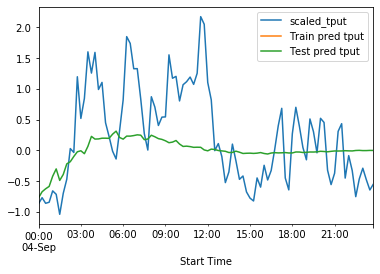

In [47]:
plot_cols=['scaled_tput','Train pred tput','Test pred tput']
df_varma.iloc[-96:][plot_cols].plot()

In [ ]:
df_filter['1st_diff']=df_filter['DL user tput'].diff(96)
df_filter['1st_diff'].fillna(df_filter['1st_diff'].median(),inplace=True)

In [ ]:
df_filter['2nd_diff'] = df_filter['1st_diff'].diff()
df_filter['2nd_diff'].fillna(df_filter['2nd_diff'].median(),inplace=True)

In [ ]:

def gridsearcharima(AR,d,MA,SAR,SD,SMA,m=96,debug=False):
    """ 
    walk-forward implementation for SARIMA with RMSE as selection metric
    """
    errors=[]
    seen_last=False
    steps_completed=0
    
    #run the below for loop for each combination of parameters. First we use Samtest to do the train/test
    #split for each step
    
    for end_of_train in range(Samtest, len(df_filter)-h+1):
        train=df_filter.iloc[:end_of_train]
        test=df_filter.iloc[end_of_train:end_of_train+h]
        
        if test.index[-1]==df_filter.index[-1]:
            seen_last=True
            
        steps_completed +=1
        
        #HW model trained for every train set split for each set of parameters
        
        
        arima=ARIMA(train['DL user tput'],order=(AR,d,MA),seasonal_order=(SAR,SD,SMA,m))
        arima_result=arima.fit()

        
        prediction_result=arima_result.get_forecast(h)
        forecast=prediction_result.predicted_mean
        #df.loc[test_idx,'AR(1)']=forecast
        
        #forecasts generated and MSE is calculated everytime and appended to a list
        #fcast=res_hw.forecast(h)
        error=np.sqrt(mean_squared_error(test['DL user tput'],forecast))
        #error=0.5
        #error=r2_score(test['DL user tput'],fcast)
        errors.append(error)
        
        if debug:
            print("seen last:",seen_last)
            print("steps completed:",steps_completed)
        
        #the mean MSE is returned from the function
    return errors

In [ ]:
#walkforward(1,1,1,0,0,0,0,debug=False)

h=96
steps=1
Samtest=len(df_filter)-h-steps+1


AR_list=[1]
d_list=[1]
MA_list=[1]
SAR_list=[1,2]
SD_list=[1]
SMA_list=[1]

tupe_of_option_lists=(
    AR_list,
    d_list,
    MA_list,
    SAR_list,
    SD_list,
    SMA_list

)


best_score=float('inf')
best_options=None

#itertools used to input the tuple of parameters to the walk-forward function.

for x in itertools.product(*tupe_of_option_lists):
    score=gridsearcharima(*x)
    
    #Best score is updated based on the mean MSE returned from walkforward function as well as the best params
    if np.mean(score) < best_score:
        print("Best score so far:",score)
        best_score=np.mean(score)
        best_options=x
        print("Best params so far:",best_options)


In [ ]:
df_filter=df[df['Cell']=='Local cell identity=2, Cell Name=eNB_2786_2']

In [ ]:

df_filter.index

#df_filter['Start Time'] = pd.to_datetime(df_filter['Start Time'])   
#df_filter.set_index('Start Time',inplace=True)

NameError: ignored

In [ ]:
df_filter[['L.Traffic.User.ULData.Avg (None)','L.Traffic.User.DLData.Avg (None)']]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


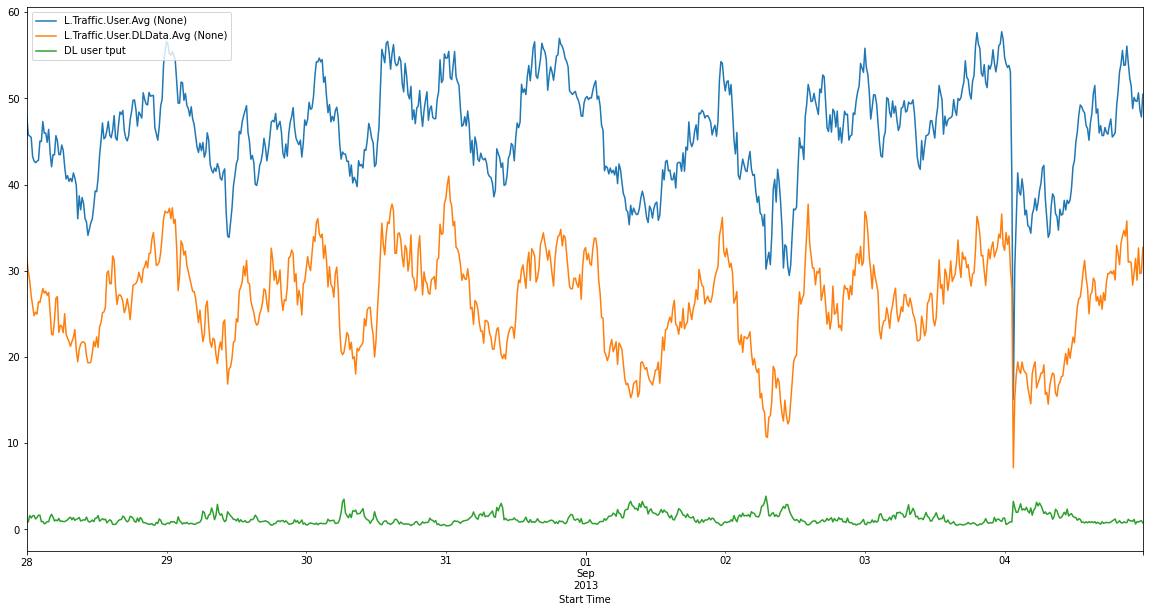

In [ ]:

df_filter['DL user tput']=df_filter['L.Thrp.bits.DL.QCI.9 (bit)']/(df_filter['L.Thrp.Time.DL.QCI.9 (ms)']*1000)

df_filter['DL cell tput']=df_filter['L.Thrp.bits.DL (bit)']/(df_filter['L.Thrp.Time.Cell.DL (s)']*1000)

df_filter[['L.Thrp.bits.DL.QCI.9 (bit)','L.Thrp.Time.DL.QCI.9 (ms)','DL user tput']]

df_filter[['L.Traffic.User.Avg (None)','L.Traffic.User.DLData.Avg (None)','DL user tput']].plot(figsize=(20,10))

In [ ]:
df.columns

Index(['Start Time', 'Cell', 'L.Traffic.UL.SCH.QPSK.ErrTB.Ibler (None)',
       'L.Traffic.UL.SCH.QPSK.ErrTB.Rbler (None)',
       'L.Traffic.UL.SCH.QPSK.TB (None)',
       'L.Traffic.UL.SCH.QPSK.TB.bits (bit)',
       'L.Traffic.UL.SCH.QPSK.TB.Retrans (None)',
       'L.Traffic.UL.SCH.QPSK.TB.Retrans.bits (bit)',
       'L.Traffic.DL.PktDelay.Num.QCI.9 (packet)',
       'L.Traffic.DL.PktDelay.Time.QCI.9 (ms)',
       'L.Traffic.DL.PktUuLoss.Loss.QCI.9 (packet)',
       'L.Traffic.DL.PktUuLoss.Tot.QCI.9 (packet)',
       'L.Traffic.UL.PktLoss.Loss.QCI.9 (packet)',
       'L.Traffic.UL.PktLoss.Tot.QCI.9 (packet)', 'DL RBLER (%)',
       'L.PDCP.DL.RoHC.HdrCompRatio (%)', 'L.PDCP.DL.RoHC.PktCompRatio (%)',
       'L.PDCP.Tx.Disc.Trf.SDU.QCI.9 (packet)',
       'L.PDCP.Tx.TotRev.Trf.SDU.QCI.9 (packet)',
       'L.PDCP.UL.RoHC.FailDecompRatio (%)', 'L.Traffic.CEU.Avg (None)',
       'L.Traffic.User.ULData.Avg (None)', 'L.Traffic.User.DLData.Avg (None)',
       'L.Traffic.User.Max (None)', 